In [1]:
"""
Created on Wed Oct 19 15:48:00 2018

@author: Daniel Cuesta, Alejandro Garo
"""

import string, random
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

import queue

from sklearn.linear_model import LinearRegression

import networkx as nx

In [2]:
def fit_plot(l, func_2_fit, size_ini, size_fin, step):
    l_func_values =[i*func_2_fit(i) for i in range(size_ini, size_fin+1, step)]
    
    lr_m = LinearRegression()
    X = np.array(l_func_values).reshape( len(l_func_values), -1 )
    lr_m.fit(X, l)
    y_pred = lr_m.predict(X)
    
    plt.plot(l, '*', y_pred, '-')

def n2_log_n(n):
    return n**2. * np.log(n)

In [3]:
l = [
[0, 10, 1, np.inf],
[np.inf, 0, 1, np.inf],
[np.inf, np.inf, 0, 1 ],
[np.inf, 1, np.inf, 0]
]

m_g = np.array(l)

def print_m_g(m_g):
    print("graph_from_matrix:\n")
    n_v = m_g.shape[0]
    for u in range(n_v):
        for v in range(n_v):
            if v != u and m_g[u, v] != np.inf:
                print("(", u, v, ")", m_g[u, v])
            
d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}

def print_d_g(d_g):
    print("\ngraph_from_dict:\n")
    for u in d_g.keys():
        for v in d_g[u].keys():
            print("(", u, v, ")", d_g[u][v])
            
print_m_g(m_g)
print_d_g(d_g)

graph_from_matrix:

( 0 1 ) 10.0
( 0 2 ) 1.0
( 1 2 ) 1.0
( 2 3 ) 1.0
( 3 1 ) 1.0

graph_from_dict:

( 0 1 ) 10
( 0 2 ) 1
( 1 2 ) 1
( 2 3 ) 1
( 3 1 ) 1


In [4]:
def rand_matr_pos_graph(n_nodes, sparse_factor, max_weight=50., decimals=0):
    
    """
    Genera una matriz de adyacencia a partir de un grafo dirigido ponderado.
    Devuelve la matriz de adyacencia.

    Parámetros
    ----------
    n_nodes : numero de nodos
    sparse_factor : proporcion de ramas
    max_weight : peso maximo
    """

    matriz = np.zeros((n_nodes,n_nodes))

    for i in range (0,n_nodes):
        for j in range (0,n_nodes):
            if i != j:
                aleat = np.random.rand()
                if aleat < sparse_factor:
                    aleat = np.random.randint(1, max_weight)
                    matriz[i][j] = aleat
                else:
                    matriz[i][j] = np.inf
    return matriz

def m_g_2_d_g(m_g):
    
    """
    Genera un diccionario de listas de adyacencia del grafo definido por la matriz.
    Devuelve el diccionario.

    Parámetros
    ----------
    m_g : matriz de adyacencia
    """

    dic = {}

    for i in range (0, m_g.shape[0]):
        tuplas = {}
        for j in range (0, m_g.shape[1]):
            if i != j:
                if np.isinf(m_g[i][j]) != True:
                    tuplas.update({j: m_g[i][j]})
        dic.update({i:tuplas})

    return dic
    

def d_g_2_m_g(d_g):
    
    """
    Genera una matriz de adyacencia del grafo definido por el diccionario.
    Devuelve la matriz.

    Parámetros
    ----------
    d_g : diccionario de listas de adyacencia
    """

    #recorrerDic
    keys = list(d_g.keys())
    max = keys[-1]

    matriz = np.zeros((max+1,max+1))

    #rellenamos infs
    for i in range (0,max+1):
        for j in range (0,max+1):
            if i != j:
                matriz[i][j] = np.inf

    print(d_g)
    #rellenamos los costes
    for i in d_g:
        for j in d_g[i]:
            matriz[i][j] = d_g[i][j]

    return matriz
    

In [5]:
m_g = rand_matr_pos_graph(n_nodes=5, sparse_factor=0.5, max_weight=50.)
d_g = m_g_2_d_g(m_g)
m_g_2 = d_g_2_m_g(d_g)

print_m_g(m_g)
print_d_g(d_g)
print("\nnum_elem_iguales:\t%d" % (m_g_2 == m_g).sum() )

{0: {2: 23.0, 3: 35.0}, 1: {4: 17.0}, 2: {0: 13.0, 1: 20.0}, 3: {1: 30.0}, 4: {1: 17.0, 2: 20.0}}
graph_from_matrix:

( 0 2 ) 23.0
( 0 3 ) 35.0
( 1 4 ) 17.0
( 2 0 ) 13.0
( 2 1 ) 20.0
( 3 1 ) 30.0
( 4 1 ) 17.0
( 4 2 ) 20.0

graph_from_dict:

( 0 2 ) 23.0
( 0 3 ) 35.0
( 1 4 ) 17.0
( 2 0 ) 13.0
( 2 1 ) 20.0
( 3 1 ) 30.0
( 4 1 ) 17.0
( 4 2 ) 20.0

num_elem_iguales:	25


In [6]:
def cuenta_ramas(m_g):
    
    """
    Cuenta el numero de ramas que hay en la matriz de adyacencia.
    Devuelve el numero de ramas.

    Parámetros
    ----------
    m_g : matriz de adyacencia
    """
    
    n_ramas = len(m_g[np.where(m_g != np.inf)]) - m_g.shape[0]
    
    return n_ramas

def check_sparse_factor(n_grafos, n_nodes, sparse_factor):
    
    """
    Genera las matrices de varios grafos aleatorios y sus proporciones.
    Devuelve la media de las proporciones.

    Parámetros
    ----------
    n_grafos : numero de grafos
    n_nodes : numero de nodos
    sparse_factor : proporcion de ramas
    """
    
    sparse_med = 0
    for i in range(0,n_grafos):
        m = rand_matr_pos_graph(n_nodes, sparse_factor)
        sparse_med += cuenta_ramas(m) / (n_nodes*n_nodes - n_nodes)

    return sparse_med/(i+1)

In [7]:
print(cuenta_ramas(m_g))

n_grafos=50
n_nodes=20
sparse_factor = 0.75

print("\ntrue_sparse_factor: %.3f" % sparse_factor, 
      "\nexp_sparse_factor:  %.3f" % check_sparse_factor(n_grafos=n_grafos, n_nodes=n_nodes, sparse_factor=sparse_factor))

8

true_sparse_factor: 0.750 
exp_sparse_factor:  0.751


In [8]:
def save_object(obj, f_name="obj.pklz", save_path='.'):
    
    """
    Guarda un objeto Python de manera comprimida en un fichero.

    Parámetros
    ----------
    obj : objeto python
    f_name : fichero donde guardar
    save_path : direccion donde guardar
    """
    
    if(save_path == '.'):
        file = gzip.GzipFile(f_name, 'wb')
    else:
        file = gzip.GzipFile(save_path+f_name, 'wb')
        
    file.write(pickle.dumps(obj))
    file.close()
    
def read_object(f_name, save_path='.'):
    
    """
    Devuelve un objeto Python guardado en un fichero.

    Parámetros
    ----------
    f_name : fichero donde leer
    save_path : direccion donde guardar
    """
    
    if(save_path == '.'):
        file = gzip.GzipFile(f_name, 'rb')
    else:
        file = gzip.GzipFile(save_path+f_name, 'rb')
    
    buffer = ""
    while True:
        data = file.read()
        if data == "":
            break
        buffer += data
        
    obj = pickle.loads(buffer)
    file.close()
    
    return obj

In [9]:
def d_g_2_TGF(d_g, f_name):
    
    """
    Guarda el grafo definido por el diccionario en un fichero.

    Parámetros
    ----------
    d_g : diccionario de listas de adyacencia
    f_name : fichero donde guardar
    """
    
    f = open(f_name, 'w')

    for key in d_g.keys():
        f.write(str(key)+"\n")
    f.write("#\n")

    for i in d_g.keys():
        for j in d_g[i].keys():
            f.write(str(i)+" ")
            f.write(str(j)+" ")
            f.write(str(d_g[i][j])+"\n")

    f.close()
    
def TGF_2_d_g(f_name):
    
    """
    Genera un diccionario de listas de adyacencia a partir de un fichero.
    Devuelve el diccionario.

    Parámetros
    ----------
    f_name : fichero donde leer
    """

    d_g = {}
    flag = 0
    
    f = open(f_name, 'r')
    
    for line in f:
        line = line.split()
        if flag == 1:
            d_g[int(line[0])].update({int(line[1]):float(line[2])})
        if line[0] == "#":
            flag = 1
        if flag == 0:
            d_g.update({int(line[0]):{}})
    f.close()
    return d_g 

In [10]:
############################################################ checking
f_name = "gr.tgf"
d_g_2_TGF(d_g, f_name)
                       
d_g_2 = TGF_2_d_g(f_name)            
print_d_g(d_g)
print_d_g(d_g_2)


graph_from_dict:

( 0 2 ) 23.0
( 0 3 ) 35.0
( 1 4 ) 17.0
( 2 0 ) 13.0
( 2 1 ) 20.0
( 3 1 ) 30.0
( 4 1 ) 17.0
( 4 2 ) 20.0

graph_from_dict:

( 0 2 ) 23.0
( 0 3 ) 35.0
( 1 4 ) 17.0
( 2 0 ) 13.0
( 2 1 ) 20.0
( 3 1 ) 30.0
( 4 1 ) 17.0
( 4 2 ) 20.0


In [11]:
def dijkstra_d(d_g, u):

    """
    Genera las tablas de previos y de distancias minimas entre 
    el vertice y los demas de un grafo dado por un diccionario.
    Devuelve las tablas de previos y de distancias minimas.

    Parámetros
    ----------
    d_g : diccionario de listas de adyacencia
    u : vertice
    """

    #u, elemento(nodo) del que se calculan distancias
    #d_g grafo en dicc

    pq = queue.PriorityQueue()
    distancia = {}
    previo = {}
    visitado = {}

    #crear diccionarios con indice el nodo y (distancia, previo, visitado)
    for i in d_g.keys():
        distancia[i] = np.inf
        previo[i] = None
        visitado[i] = False

    #la distancia en u es cero
    distancia[u]=0
    
    #insertamos en la pq la tupla (d[u], u)
    pq.put((distancia[u], u))
    previo[u] = u

    #Bucle mientras pq no vacia:
    while pq.empty() == False:
        #Escogemos la primera tupla de la pq y pasamos a este nodo n
        _, n = pq.get()
        #Si este nodo no ha sido visitado lo visitamos v[n] = True
        if visitado[n] == False:
            visitado[n] = True

            #Para cada camino z en todos los caminos de n
            caminos = d_g[n]
            for z in caminos.keys():
                coste_n_z = d_g[n][z]

                #Si distancia[z] > (distancia[n] + coste(n, z):
                if distancia[z] > (distancia[n] + coste_n_z):
                    #distancia[z] = (distancia[n] + coste(n, z)
                    distancia[z] = (distancia[n] + coste_n_z)
                    #previo[z] = n
                    previo[z] = n
                    #insertamos tupla (d[z], z) en pq
                    pq.put((distancia[z],z))

    return distancia, previo
   
def min_paths(d_prev):
    """
    Genera los caminos minimos desde un vertice a los demas 
    vertices del grafo.
    Devuelve un diccionario con los caminos entre vertices.

    Parámetros
    ----------
    d_prev : diccionario de previos
    """
    
    d_paths = {}
    l_paths = []
    
    for prev in d_prev.keys():
        prev_aux = prev
        
        if d_prev[prev] is None:
            continue
            
        while d_prev[prev_aux] != prev_aux:
            l_paths.append(prev_aux)
            prev_aux = d_prev[prev_aux]
        
        if d_prev[prev_aux] == prev_aux:
            l_paths.append(prev_aux)
            
        d_paths[prev] = l_paths[::-1]
        l_paths = []

    return d_paths

def time_dijkstra_m(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
   
    """
    Mide los tiempos que tarda en ejecutar el algoritmo de Dijkstra
    sobre diferentes grafos con diferentes cantidades de nodos dados en 
    matrices.
    Devuelve los tiempos.

    Parámetros
    ----------
    n_graphs : numero de grafos
    n_nodes_ini : tamaño de inicio
    n_nodes_fin : tamaño de fin
    step : incremento
    sparse_factor : proporcion de ramas
    """
    l_time = []
    n_nodes = n_nodes_ini

    while n_nodes <= n_nodes_fin:
        #tiempo inicial
        time1 = time.clock()
        for i in range(n_graphs):		
            #genera grafo en matriz
            matriz = rand_matr_pos_graph(n_nodes, sparse_factor)
            #dijkstra en matriz para cada u
            for u in range(matriz.shape[0]-1):
                dijkstra_m(matriz, u)

        #tiempo final
        time2 = time.clock()
        l_time.append(time2 - time1)
        n_nodes += step

    return l_time


def time_dijkstra_d(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Mide los tiempos que tarda en ejecutar el algoritmo de Dijkstra
    sobre diferentes grafos con diferentes cantidades de nodos dados en diccionarios.
    Devuelve los tiempos.

    Parámetros
    ----------
    n_graphs : numero de grafos
    n_nodes_ini : tamaño de inicio
    n_nodes_fin : tamaño de fin
    step : incremento
    sparse_factor : proporcion de ramas
    """
    
    l_time = []
    n_nodes = n_nodes_ini
    
    while n_nodes <= n_nodes_fin:
        #tiempo inicial
        time1 = time.clock()
        for i in range(n_graphs):
            #genera grafo en matriz
            matriz = rand_matr_pos_graph(n_nodes, sparse_factor)
            #genera dic a partir de matriz
            dic = m_g_2_d_g(matriz)
            #dijkstra en dic para cada u
            for u in dic.keys():
                dijkstra_d(dic, u)
        #tiempo final
        time2 = time.clock()
        l_time.append(time2 - time1)
        n_nodes += step
        
    return l_time
    


In [12]:
############################################################ checking
d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}

u_ini = 3

d_dist, d_prev = dijkstra_d(d_g, u_ini)
print(d_dist, '\n', min_paths(d_prev))

d_g_nx = nx.DiGraph()
l_e = [(0, 1, 10), (0, 2, 1), (1, 2, 1), (2, 3, 1), (3, 1, 1)]
d_g_nx.add_weighted_edges_from(l_e)

d, p = nx.single_source_dijkstra(d_g_nx, u_ini, weight='weight')    
print("NX:")
print(d, '\n', p)

{0: inf, 1: 1, 2: 2, 3: 0} 
 {1: [3, 1], 2: [3, 1, 2], 3: [3]}
NX:
{1: 1, 2: 2, 3: 0} 
 {1: [3, 1], 2: [3, 1, 2], 3: [3]}


In [13]:
n_graphs=20
n_nodes_ini=10 
n_nodes_fin=100
step=10
sparse_f= 0.25
l_t_d = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

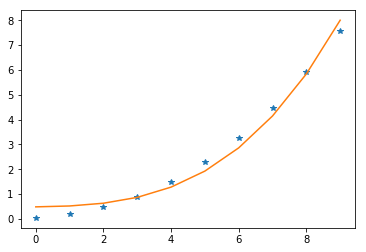

In [14]:
fit_plot(l_t_d, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)

In [15]:
# Ejemplo de carga de grafos en NX. Lista (i, j, w), donde para cada par de nodos (i, j) su peso es w
g = nx.DiGraph()

l_e = [(0, 1, 10), (0, 2, 1), (1, 2, 1), (2, 3, 1), (3, 1, 1)]
g.add_weighted_edges_from(l_e)

for k1 in g.nodes():
    for k2 in g[k1].keys():
        print('(', k1, k2, ')', g[k1][k2]['weight'])

( 0 1 ) 10
( 0 2 ) 1
( 1 2 ) 1
( 2 3 ) 1
( 3 1 ) 1


In [16]:
def d_g_2_nx_g(d_g):
    """
    Dado un grafo, lo transforma a uno de la librería NX.
    Busca los caminos entre nodos y su peso, crea una lista con todos ellos y usa el método 
    nx.add_weighted_edges_from para crear el grafo NX.
    
    Parámetros
    ----------
    d_g : grafo dirigido
    """
    d_g_nx = nx.DiGraph()
    l_e = []
    
    for k in d_g.keys():
        for adj in d_g[k]:
            l_e.append([k, adj, d_g[k][adj]])
            
    d_g_nx.add_weighted_edges_from(l_e)

    return d_g_nx
    

def nx_g_2_d_g(nx_g):
    """
    Dado un grafo de la librería NX, lo transforma a uno con nuestro formato.
    
    Parámetros
    ----------
    nx_g : grafo dirigido NX
    """
    d_g = {}
    for k in nx_g:
        d_g[k] = {}
        for adj in nx_g[k]:
            d_g[k][adj] = nx_g[k][adj]['weight']

    return d_g
    
    
def time_dijkstra_nx(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Mide los tiempos que tarda en ejecutar el algoritmo de Dijkstra
    sobre diferentes grafos con diferentes cantidades de nodos dados en grafos NX.
    Devuelve una lista con los tiempos para cada ejecucion del algoritmo de Dijkstra.

    Parámetros
    ----------
    n_graphs : numero de grafos
    n_nodes_ini : tamaño de inicio
    n_nodes_fin : tamaño de fin
    step : incremento
    sparse_factor : proporcion de ramas
    """
    
    l_time = []
    n_nodes = n_nodes_ini
    
    while n_nodes <= n_nodes_fin:
        #tiempo inicial
        time1 = time.clock()
        for i in range(n_graphs):
            #genera grafo en matriz
            matriz = rand_matr_pos_graph(n_nodes, sparse_factor)
            #genera dic a partir de matriz
            d_g = m_g_2_d_g(matriz)
            #dijkstra en dic para cada u
            nx_g = d_g_2_nx_g(d_g)
            for u in nx_g:
                nx.single_source_dijkstra(nx_g, u, weight='weight')
        #tiempo final
        time2 = time.clock()
        l_time.append(time2 - time1)
        n_nodes += step
        
    return l_time

In [17]:
############################################################ checking
d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}

d_g_nx = d_g_2_nx_g(d_g)

print_d_g(d_g)
(d_g_nx)[0][1]


graph_from_dict:

( 0 1 ) 10
( 0 2 ) 1
( 1 2 ) 1
( 2 3 ) 1
( 3 1 ) 1


{'weight': 10}

In [18]:
n_graphs=20
n_nodes_ini=10 
n_nodes_fin=100
step=10
sparse_f= 0.25
l_t_nx = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

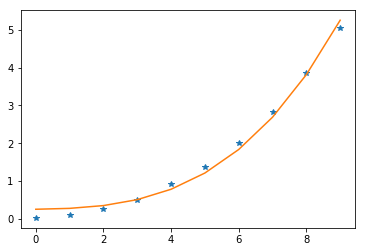

In [19]:
fit_plot(l_t_nx, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)